In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_798', 'test_835', 'test_634', 'test_768', 'test_272', 'test_649', 'test_147', 'test_852', 'test_94', 'test_1318', 'test_1237', 'test_964', 'test_1036', 'test_95', 'test_311', 'test_706', 'test_194', 'test_438', 'test_920', 'test_900', 'test_857', 'test_88', 'test_7', 'test_994', 'test_1000', 'test_1259', 'test_859', 'test_1141', 'test_726', 'test_877', 'test_442', 'test_1164', 'test_323', 'test_1276', 'test_299', 'test_987', 'test_121', 'test_729', 'test_132', 'test_1315', 'test_905', 'test_615', 'test_879', 'test_707', 'test_923', 'test_562', 'test_27', 'test_60', 'test_948', 'test_596', 'test_790', 'test_1121', 'test_44', 'test_656', 'test_745', 'test_380', 'test_378', 'test_1026', 'test_65', 'test_967', 'test_867', 'test_18', 'test_661', 'test_850', 'test_276', 'test_1305', 'test_622', 'test_348', 'test_1301', 'test_1050', 'test_1014', 'test_255', 'test_294', 'test_356', 'test_840', 'test_1013', 'test_304', 'test_583', 'test_743', 'test_1114', 'test_969', 'test_674', 'tes

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_647', 'test_1284', 'test_506', 'test_1054', 'test_524', 'test_697', 'test_654', 'test_416', 'test_1264', 'test_1152', 'test_1198', 'test_350', 'test_279', 'test_1182', 'test_485', 'test_142', 'test_511', 'test_16', 'test_399', 'test_1279', 'test_471', 'test_145', 'test_807', 'test_412', 'test_796', 'test_288', 'test_653', 'test_259', 'test_450', 'test_470', 'test_788', 'test_187', 'test_748', 'test_1115', 'test_447', 'test_684', 'test_837', 'test_836', 'test_170', 'test_715', 'test_1200', 'test_456', 'test_1293', 'test_809', 'test_1283', 'test_679', 'test_628', 'test_753', 'test_1104', 'test_556', 'test_575', 'test_308', 'test_1285', 'test_609', 'test_614', 'test_643', 'test_284', 'test_135', 'test_1170', 'test_883', 'test_863', 'test_1028', 'test_892', 'test_631', 'test_309', 'test_270', 'test_386', 'test_862', 'test_99', 'test_405', 'test_983', 'test_19', 'test_930', 'test_1248', 'test_932', 'test_1024', 'test_1058', 'test_441', 'test_1261', 'test_137', 'test_360', 'test_3

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [24]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [25]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [26]:
find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

Prompt: test_798 

Count: 0
Incorrect Baseline Generation: 

n0=10
n1=0.5
n2=1.0
n3=20
t0=n0+n1
t1=n0+t0
t2=t1+n2
t3=t2+t1
t4=t3+t1
answer=t4-t3

Generated Answer: 20.5
----------------------------------------------------------------
Correct S3C Generation: 

n0=10
n1=0.5
n2=1.0
n3=20
t0=n0+n1
t1=n0+n2
t2=t0+t1
t3=n3*n0
t4=n3*t1
answer=t4-t3

Generated Answer: 20.0
----------------------------------------------------------------
Ground Truth Program: 

n0=10
n1=0.5
n2=1.0
n3=20
t0=n0+n1+n2
t1=n0+n1
t2=n3*t0
answer=n3*t1
Ground Truth Answer: 20.0
----------------------------------------------------------------
Notes: 
|=================================================================================================================================|

Prompt: test_634 

Count: 1
Incorrect Baseline Generation: 

n0=17
n1=3
n2=6
t0=n0+n1
t1=t0-n2
answer=n0+t0+t1

Generated Answer: 51
----------------------------------------------------------------
Correct S3C Generation: 

n0=17
n1=6
n2=3
t0

In [27]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [28]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [29]:
print(ft_intersection)

['test_647', 'test_1284', 'test_506', 'test_1054', 'test_524', 'test_697', 'test_654', 'test_416', 'test_1264', 'test_1152', 'test_1198', 'test_350', 'test_279', 'test_1182', 'test_485', 'test_142', 'test_511', 'test_16', 'test_399', 'test_1279', 'test_471', 'test_145', 'test_807', 'test_412', 'test_796', 'test_288', 'test_653', 'test_259', 'test_450', 'test_470', 'test_788', 'test_187', 'test_748', 'test_1115', 'test_447', 'test_684', 'test_837', 'test_836', 'test_170', 'test_715', 'test_1200', 'test_456', 'test_1293', 'test_809', 'test_1283', 'test_679', 'test_628', 'test_753', 'test_1104', 'test_556', 'test_575', 'test_308', 'test_1285', 'test_609', 'test_614', 'test_643', 'test_284', 'test_135', 'test_1170', 'test_883', 'test_863', 'test_1028', 'test_892', 'test_631', 'test_309', 'test_270', 'test_386', 'test_862', 'test_99', 'test_405', 'test_983', 'test_19', 'test_930', 'test_1248', 'test_932', 'test_1024', 'test_1058', 'test_441', 'test_1261', 'test_137', 'test_360', 'test_396',

In [30]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re
import ast
import operator as op

# Function to parse the string and extract variables, values, operators, and dependencies
# def parse_string_to_graph(string):
#     graph = nx.DiGraph()
#     values = {}

#     lines = string.strip().split("\n")
#     for idx, line in enumerate(lines):
#         line = line.strip()
#         match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
#         if match:
#             var = match.group(1)
#             expr = match.group(2)

#             # Find dependencies and operators using regex
#             dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
#             operators = re.findall(r"([\*+/-])", expr)
            
#             for i, op in enumerate(operators):
#                 op_node = f"{idx}:({op})"
#                 # add edges for operands and operations
#                 graph.add_edge(dependencies[i], op_node)
#                 graph.add_edge(dependencies[i+1], op_node)
#                 graph.add_edge(op_node, var)
                
#                 # calculate the value
#                 if op == '*':
#                     values[var] = values[dependencies[i]] * values[dependencies[i+1]]
#                 elif op == '+':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] + values[dependencies[i+1]]
#                 elif op == '-':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] - values[dependencies[i+1]]
#                 elif op == '/':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] / values[dependencies[i+1]]

#             # If no operator is found, then it's a direct assignment
#             if not operators:
#                 try:
#                     value = int(expr)
#                 except ValueError:
#                     try:
#                         value = float(expr)
#                     except ValueError:
#                         value = None  # Expression is not a numeric value
#                 values[var] = value
#                 graph.add_node(var, value=values[var])
#             else:
#                 graph.add_node(var, value=values[var])

#     return graph

operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul, ast.Div: op.truediv}

# Operator symbols
op_symbols = {ast.Add: "+", ast.Sub: "-", ast.Mult: "*", ast.Div: "/"}

def eval_expr(node, values):
    """Evaluates an expression in the correct order of operations."""
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_expr(node.left, values), eval_expr(node.right, values))
    elif isinstance(node, ast.Name): # <variable>
        return values[node.id] # Return the variable's value
    else:
        raise TypeError(node)

def parse_string_to_graph(string, name=None):
    graph = nx.DiGraph()
    values = {}
    
    if name is not None:
        graph.name = name
    
    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Parse the expression into an ast
            node = ast.parse(expr, mode='eval').body

            # If the expression is a number, save its value
            if isinstance(node, ast.Num):
                values[var] = node.n
            else: # If the expression is a variable or operation, compute its value
                values[var] = eval_expr(node, values)

            # Add the node to the graph with its value
            graph.add_node(var, value=values[var])

            # Add edges to the graph for each variable used in the expression
            vars_used = [n.id for n in ast.walk(node) if isinstance(n, ast.Name)]
            for v in vars_used:
                graph.add_edge(v, var)

            # Add operator nodes and edges
            operators_used = [type(n) for n in ast.walk(node) if type(n) in operators.keys()]
            for idx, op in enumerate(operators_used):
                op_node = f"{var}_{idx}:({op_symbols[op]})"
                graph.add_node(op_node)
                graph.add_edge(vars_used[idx], op_node)
                graph.add_edge(vars_used[idx+1], op_node)
                graph.add_edge(op_node, var)

    return graph
# # Create the graph for the input string
# baseline_graph = parse_string_to_graph(correct_string)
# s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
# baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
# s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

In [31]:
def compute_graph_metrics(graph):
    metrics = {
        'topological_order': list(nx.topological_sort(graph)),
        'num_nodes': graph.number_of_nodes(),
        'num_edges': graph.number_of_edges(),
    }
    
    return metrics


In [32]:
# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

In [33]:
def display_graphs(correct_string, incorrect_string, prompt):
    # Create the graph for the input string
    correct_graph = parse_string_to_graph(correct_string)
    incorrect_graph = parse_string_to_graph(incorrect_string)

#     # Create label mapping
#     correct_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in correct_graph.nodes(data=True)}
#     incorrect_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in incorrect_graph.nodes(data=True)}    
    
    # Create a subgraph isomorphism matcher
    matcher = iso.DiGraphMatcher(correct_graph, incorrect_graph)

    # Find all subgraph isomorphisms (common patterns)
    subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

    # Find the nodes with the same variable names in both graphs
    shared_variable_nodes = set(correct_graph.nodes()) & set(incorrect_graph.nodes())

    # Get the variable values for each graph
    var_values_correct = nx.get_node_attributes(correct_graph, "value")
    var_values_incorrect = nx.get_node_attributes(incorrect_graph, "value")

    # Identify nodes with different values between the graphs
    different_value_nodes = {node for node in shared_variable_nodes if var_values_correct.get(node) != var_values_incorrect.get(node)}

    # Get the expressions for each graph
    expressions_correct = {node: data["expression"] for node, data in correct_graph.nodes(data=True) if "expression" in data}
    expressions_incorrect = {node: data["expression"] for node, data in incorrect_graph.nodes(data=True) if "expression" in data}

    # Identify nodes with different expressions between the graphs
    different_expression_nodes = {node for node in shared_variable_nodes if expressions_correct.get(node) != expressions_incorrect.get(node)}

    # Set node attributes and labels for visualization
    set_node_attributes(correct_graph, var_values_correct, expressions_correct)
    set_node_attributes(incorrect_graph, var_values_incorrect, expressions_incorrect)


    # Compare the operators between the graphs
    operator_values_correct = {node: data["expression"] for node, data in correct_graph.nodes(data=True) if "expression" in data}
    operator_values_incorrect = {node: data["expression"] for node, data in incorrect_graph.nodes(data=True) if "expression" in data}
    different_operator_nodes = {node for node in set(operator_values_correct) & set(operator_values_incorrect) if operator_values_correct[node] != operator_values_incorrect[node]}

    # Find the nodes and edges that are unique to each graph
    unique_nodes_correct = set(node for node in correct_graph.nodes() if node not in incorrect_graph.nodes() or (node in shared_variable_nodes and var_values_correct.get(node) != var_values_incorrect.get(node)))
    unique_nodes_incorrect = set(node for node in incorrect_graph.nodes() if node not in correct_graph.nodes() or (node in shared_variable_nodes and var_values_incorrect.get(node) != var_values_correct.get(node)))

    unique_edges_correct = set((u, v) for u, v, data in correct_graph.edges(data=True) if (u, v) not in incorrect_graph.edges() and data.get("operator") is None)
    unique_edges_incorrect = set((u, v) for u, v, data in incorrect_graph.edges(data=True) if (u, v) not in correct_graph.edges() and data.get("operator") is None)

    # Create a new figure and axis for drawing the graphs
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    # Draw the baseline graph
    #axes[0].set_title("Correct Baseline Generation")
    prompt_num = prompt
    
    axes[0].set_title(f"{prompt_num}        Ground Truth Program")
    pos_correct = nx.spring_layout(correct_graph, seed=42)
    labels_correct = nx.get_node_attributes(correct_graph, "label")
    colors_correct = nx.get_node_attributes(correct_graph, "color")
    nx.draw(correct_graph, pos=pos_correct, labels=labels_correct, node_color=list(colors_correct.values()), node_size=500, font_size=10, ax=axes[0])

    # Draw the s3c graph
    axes[1].set_title("Incorrect Baseline Generated Program")
    pos_incorrect = nx.spring_layout(incorrect_graph, seed=42)
    labels_incorrect = nx.get_node_attributes(incorrect_graph, "label")
    colors_incorrect = nx.get_node_attributes(incorrect_graph, "color")
    nx.draw(incorrect_graph, pos=pos_incorrect, labels=labels_incorrect, node_color=list(colors_incorrect.values()), node_size=500, font_size=10, ax=axes[1])

    # Highlight nodes with different values between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

    # Highlight nodes with different expressions between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])


    # Highlight nodes with different operators between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=unique_nodes_incorrect, node_color="pink", node_size=500, ax=axes[1])

    plt.tight_layout()
    plt.show()
    
    correct_graph_metrics = compute_graph_metrics(correct_graph)
    incorrect_graph_metrics = compute_graph_metrics(incorrect_graph)
    
#     print("Basline Graph Metrics")
#     pprint(incorrect_graph_metrics)   
#     print("\n")
    
#     print("GT Graph Metrics")
#     pprint(correct_graph_metrics)
    
    

    # Print the unique nodes and edges in each graph
    print(prompt)
    print("Unique nodes in GT Graph:", unique_nodes_correct)
    print("Unique nodes in Basline Graph:", unique_nodes_incorrect)

    print("Unique edges in GT Graph:", unique_edges_correct)
    print("Unique edges in GT Graph:", unique_edges_incorrect)


In [34]:
def display_graphs_nc(correct_graph, incorrect_graph):  
    
    # Create a subgraph isomorphism matcher
    matcher = iso.DiGraphMatcher(correct_graph, incorrect_graph)

    # Find all subgraph isomorphisms (common patterns)
    subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

    # Find the nodes with the same variable names in both graphs
    shared_variable_nodes = set(correct_graph.nodes()) & set(incorrect_graph.nodes())

    # Get the variable values for each graph
    var_values_correct = nx.get_node_attributes(correct_graph, "value")
    var_values_incorrect = nx.get_node_attributes(incorrect_graph, "value")

    # Identify nodes with different values between the graphs
    different_value_nodes = {node for node in shared_variable_nodes if var_values_correct.get(node) != var_values_incorrect.get(node)}

    # Get the expressions for each graph
    expressions_correct = {node: data["expression"] for node, data in correct_graph.nodes(data=True) if "expression" in data}
    expressions_incorrect = {node: data["expression"] for node, data in incorrect_graph.nodes(data=True) if "expression" in data}

    # Identify nodes with different expressions between the graphs
    different_expression_nodes = {node for node in shared_variable_nodes if expressions_correct.get(node) != expressions_incorrect.get(node)}

    # Set node attributes and labels for visualization
    set_node_attributes(correct_graph, var_values_correct, expressions_correct)
    set_node_attributes(incorrect_graph, var_values_incorrect, expressions_incorrect)


    # Compare the operators between the graphs
    operator_values_correct = {node: data["expression"] for node, data in correct_graph.nodes(data=True) if "expression" in data}
    operator_values_incorrect = {node: data["expression"] for node, data in incorrect_graph.nodes(data=True) if "expression" in data}
    different_operator_nodes = {node for node in set(operator_values_correct) & set(operator_values_incorrect) if operator_values_correct[node] != operator_values_incorrect[node]}

    # Find the nodes and edges that are unique to each graph
    unique_nodes_correct = set(node for node in correct_graph.nodes() if node not in incorrect_graph.nodes() or (node in shared_variable_nodes and var_values_correct.get(node) != var_values_incorrect.get(node)))
    unique_nodes_incorrect = set(node for node in incorrect_graph.nodes() if node not in correct_graph.nodes() or (node in shared_variable_nodes and var_values_incorrect.get(node) != var_values_correct.get(node)))

    unique_edges_correct = set((u, v) for u, v, data in correct_graph.edges(data=True) if (u, v) not in incorrect_graph.edges() and data.get("operator") is None)
    unique_edges_incorrect = set((u, v) for u, v, data in incorrect_graph.edges(data=True) if (u, v) not in correct_graph.edges() and data.get("operator") is None)

    # Create a new figure and axis for drawing the graphs
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    # Draw the baseline graph
    #axes[0].set_title("Correct Baseline Generation")
    #prompt_num = prompt
    
    axes[0].set_title("Ground Truth Program")
    pos_correct = nx.spring_layout(correct_graph, seed=42)
    labels_correct = nx.get_node_attributes(correct_graph, "label")
    colors_correct = nx.get_node_attributes(correct_graph, "color")
    nx.draw(correct_graph, pos=pos_correct, labels=labels_correct, node_color=list(colors_correct.values()), node_size=500, font_size=10, ax=axes[0])

    # Draw the s3c graph
    axes[1].set_title("Incorrect Baseline Generated Program")
    pos_incorrect = nx.spring_layout(incorrect_graph, seed=42)
    labels_incorrect = nx.get_node_attributes(incorrect_graph, "label")
    colors_incorrect = nx.get_node_attributes(incorrect_graph, "color")
    nx.draw(incorrect_graph, pos=pos_incorrect, labels=labels_incorrect, node_color=list(colors_incorrect.values()), node_size=500, font_size=10, ax=axes[1])

    # Highlight nodes with different values between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

    # Highlight nodes with different expressions between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])


    # Highlight nodes with different operators between the graphs in red
    nx.draw_networkx_nodes(incorrect_graph, pos=pos_incorrect, nodelist=unique_nodes_incorrect, node_color="pink", node_size=500, ax=axes[1])

    prompt_number = re.search(r'\d+', correct_graph.name).group()
    plt.suptitle(f"Prompt no. {prompt_number}")
    
    plt.tight_layout()
    plt.show()
    
    correct_graph_metrics = compute_graph_metrics(correct_graph)
    incorrect_graph_metrics = compute_graph_metrics(incorrect_graph)
    
#     print("Basline Graph Metrics")
#     pprint(incorrect_graph_metrics)   
#     print("\n")
    
#     print("GT Graph Metrics")
#     pprint(correct_graph_metrics)
    
    

    # Print the unique nodes and edges in each graph
    #print(correct_graph.name)
    print("Unique nodes in GT Graph:", unique_nodes_correct)
    print("Unique nodes in Basline Graph:", unique_nodes_incorrect)

    print("Unique edges in GT Graph:", unique_edges_correct)
    print("Unique edges in GT Graph:", unique_edges_incorrect)


In [35]:
#display_graphs(correct_string, incorrect_string)

In [36]:
def print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                baseline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                #s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                gt_program = s3c_dict[prompt][s3c_cluster[0]]['ground_truth_program']
                
                display_graphs(gt_program, baseline_program, prompt)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"GT Answer {gt_ans} , S3C Generated Answer: {gen_ans_b}") 
                
                print("----------------------------------------------------------------")

In [37]:
def print_single_graph_comparison(prompt, tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    if prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                baseline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                #s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                gt_program = s3c_dict[prompt][s3c_cluster[0]]['ground_truth_program']
                
                display_graphs(gt_program, baseline_program, prompt)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"GT Answer {gt_ans} , Basline Generated Answer: {gen_ans_b}") 
                print("----------------------------------------------------------------")
                
            else: print("Wrong round num, round num is ", s3c_dict[prompt][s3c_cluster[0]]['round_no'])
                
        else:
            print("Prompt not in intersection")

In [38]:
print( len(filter_failed_prompts(baseline_dict)) )

745


In [39]:
def generate_graph_list_debug( prompt_ids, prompt_dict, clusters ):
    for prompt in prompt_ids:
        longest_cluster = (get_longest(clusters[prompt])) #longest correct/incorrect cluster
        
        incorrect_generated_program = prompt_dict[prompt][longest_cluster[0]]['generated_program']
        gt_program = prompt_dict[prompt][longest_cluster[0]]['ground_truth_program']
        display_graphs_nc(gt_program, incorrect_generated_program, prompt)
        
        gt_ans = prompt_dict[prompt][longest_cluster[0]]['expected_answer']
        gen_ans_b = prompt_dict[prompt][longest_cluster[0]]['compiler_output'][2]
        print(f"GT Answer {gt_ans} , Basline Generated Answer: {gen_ans_b}") 
        print("----------------------------------------------------------------")        

In [40]:
def generate_graph_lists( prompt_ids, prompt_dict, clusters ):
    generated_graph_list = []
    gt_graph_list = []
    
    for prompt in prompt_ids:
        longest_cluster = (get_longest(clusters[prompt])) #longest correct/incorrect cluster
        
        generated_program = prompt_dict[prompt][longest_cluster[0]]['generated_program']
        gt_program = prompt_dict[prompt][longest_cluster[0]]['ground_truth_program']
        
        generated_graph_name = f"{prompt}_generated"
        gt_graph_name = f"{prompt}_gt"    
        
        generated_graph = parse_string_to_graph(generated_program, generated_graph_name)
        gt_graph = parse_string_to_graph(gt_program, gt_graph_name)    

        # Add the modified graph objects to the lists
        generated_graph_list.append(generated_graph)
        gt_graph_list.append(gt_graph)

    return generated_graph_list, gt_graph_list

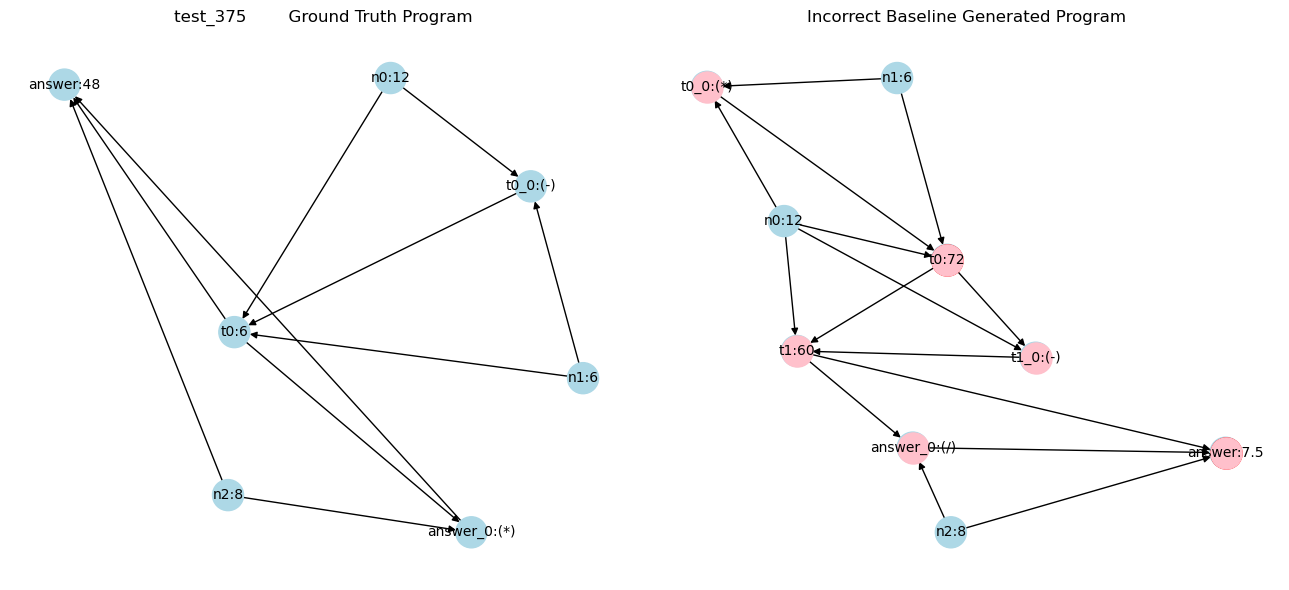

test_375
Unique nodes in GT Graph: {'t0', 'answer_0:(*)', 'answer', 't0_0:(-)'}
Unique nodes in Basline Graph: {'answer', 'answer_0:(/)', 't0', 't0_0:(*)', 't1', 't1_0:(-)'}
Unique edges in GT Graph: {('n2', 'answer_0:(*)'), ('n1', 't0_0:(-)'), ('t0', 'answer'), ('answer_0:(*)', 'answer'), ('t0', 'answer_0:(*)'), ('t0_0:(-)', 't0'), ('n0', 't0_0:(-)')}
Unique edges in GT Graph: {('n1', 't0_0:(*)'), ('t0_0:(*)', 't0'), ('t1', 'answer_0:(/)'), ('t1', 'answer'), ('n2', 'answer_0:(/)'), ('n0', 't0_0:(*)'), ('n0', 't1_0:(-)'), ('n0', 't1'), ('t0', 't1'), ('t0', 't1_0:(-)'), ('answer_0:(/)', 'answer'), ('t1_0:(-)', 't1')}
GT Answer 48.0 , Basline Generated Answer: 7.5
----------------------------------------------------------------


In [41]:
print_single_graph_comparison('test_375', tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters)

In [42]:
#print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters)

In [43]:
failed_baseline_ids = filter_failed_prompts(baseline_dict)

In [44]:
#generate_graph_list( failed_baseline_ids, baseline_dict, incorrect_baseline_clusters )

In [45]:
graph_lists = generate_graph_lists( failed_baseline_ids, baseline_dict, incorrect_baseline_clusters )

In [46]:
print(len(graph_lists[0]))
print(len(graph_lists[1]))

745
745


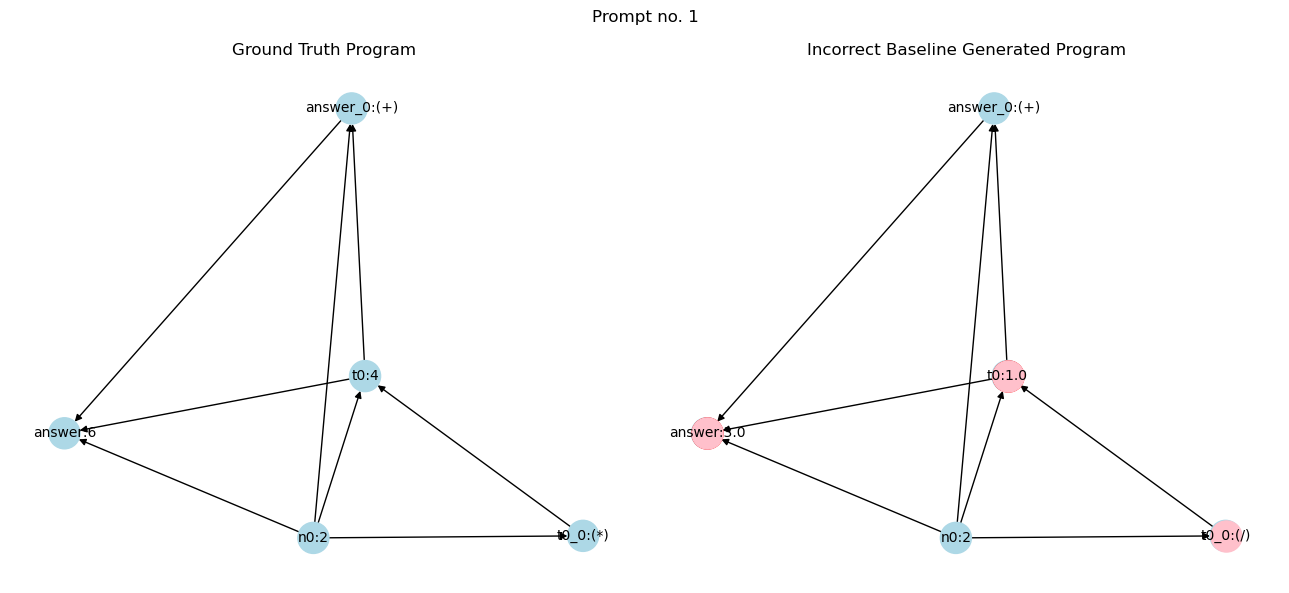

Unique nodes in GT Graph: {'t0', 'answer', 't0_0:(*)'}
Unique nodes in Basline Graph: {'t0', 'answer', 't0_0:(/)'}
Unique edges in GT Graph: {('t0_0:(*)', 't0'), ('n0', 't0_0:(*)')}
Unique edges in GT Graph: {('n0', 't0_0:(/)'), ('t0_0:(/)', 't0')}


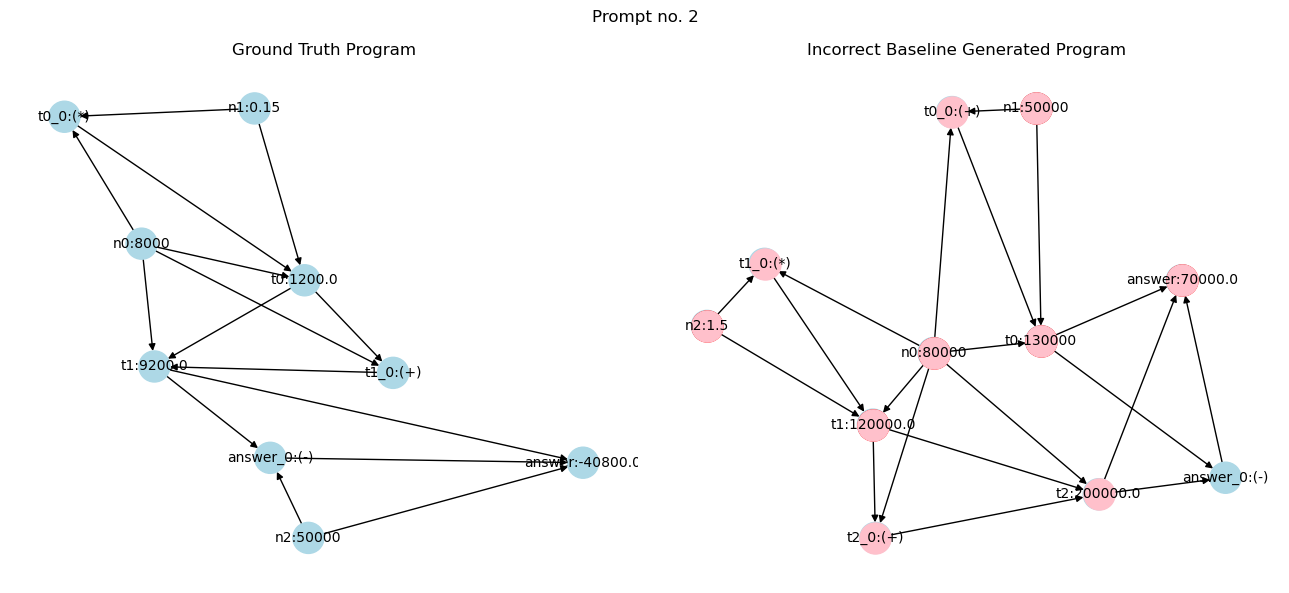

Unique nodes in GT Graph: {'n0', 'answer', 't0', 't0_0:(*)', 't1', 't1_0:(+)', 'n1', 'n2'}
Unique nodes in Basline Graph: {'n0', 't1_0:(*)', 't2_0:(+)', 't0_0:(+)', 'answer', 't0', 't1', 't2', 'n1', 'n2'}
Unique edges in GT Graph: {('n1', 't0_0:(*)'), ('t0_0:(*)', 't0'), ('t1_0:(+)', 't1'), ('n2', 'answer_0:(-)'), ('t1', 'answer'), ('n2', 'answer'), ('t0', 't1_0:(+)'), ('n0', 't0_0:(*)'), ('t0', 't1'), ('n0', 't1_0:(+)'), ('t1', 'answer_0:(-)')}
Unique edges in GT Graph: {('n0', 't0_0:(+)'), ('n0', 't2_0:(+)'), ('t0', 'answer_0:(-)'), ('n2', 't1_0:(*)'), ('t1', 't2_0:(+)'), ('t2_0:(+)', 't2'), ('t2', 'answer'), ('n1', 't0_0:(+)'), ('t0', 'answer'), ('t2', 'answer_0:(-)'), ('t0_0:(+)', 't0'), ('t1_0:(*)', 't1'), ('n0', 't2'), ('t1', 't2'), ('n2', 't1'), ('n0', 't1_0:(*)')}


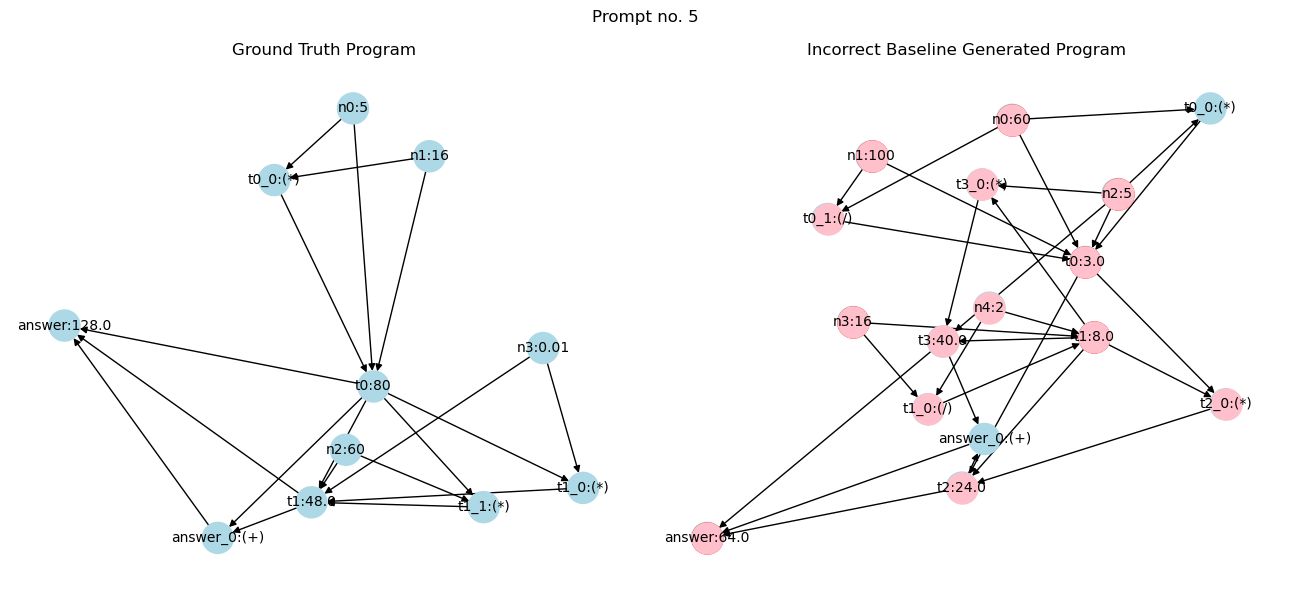

Unique nodes in GT Graph: {'n3', 'n0', 't1_0:(*)', 'answer', 't0', 't1', 't1_1:(*)', 'n1', 'n2'}
Unique nodes in Basline Graph: {'n3', 't2_0:(*)', 'n0', 't3_0:(*)', 'answer', 'n4', 't1_0:(/)', 't0_1:(/)', 't0', 't1', 't3', 't2', 'n1', 'n2'}
Unique edges in GT Graph: {('n1', 't0_0:(*)'), ('t1', 'answer'), ('t1_1:(*)', 't1'), ('t0', 'answer'), ('t0', 't1_1:(*)'), ('t1', 'answer_0:(+)'), ('t0', 'answer_0:(+)'), ('t0', 't1'), ('n2', 't1_1:(*)'), ('t1_0:(*)', 't1'), ('n3', 't1_0:(*)'), ('n2', 't1'), ('t0', 't1_0:(*)')}
Unique edges in GT Graph: {('t1', 't3_0:(*)'), ('t1_0:(/)', 't1'), ('n2', 't0_0:(*)'), ('t1', 't2'), ('n4', 't1_0:(/)'), ('n4', 't1'), ('t3', 'answer'), ('t0', 't2'), ('t2', 'answer_0:(+)'), ('n0', 't0_1:(/)'), ('t2_0:(*)', 't2'), ('n1', 't0_1:(/)'), ('t3_0:(*)', 't3'), ('n2', 't3'), ('t1', 't2_0:(*)'), ('t0', 't2_0:(*)'), ('t0_1:(/)', 't0'), ('t3', 'answer_0:(+)'), ('t1', 't3'), ('n2', 't0'), ('n2', 't3_0:(*)'), ('n3', 't1_0:(/)'), ('t2', 'answer')}


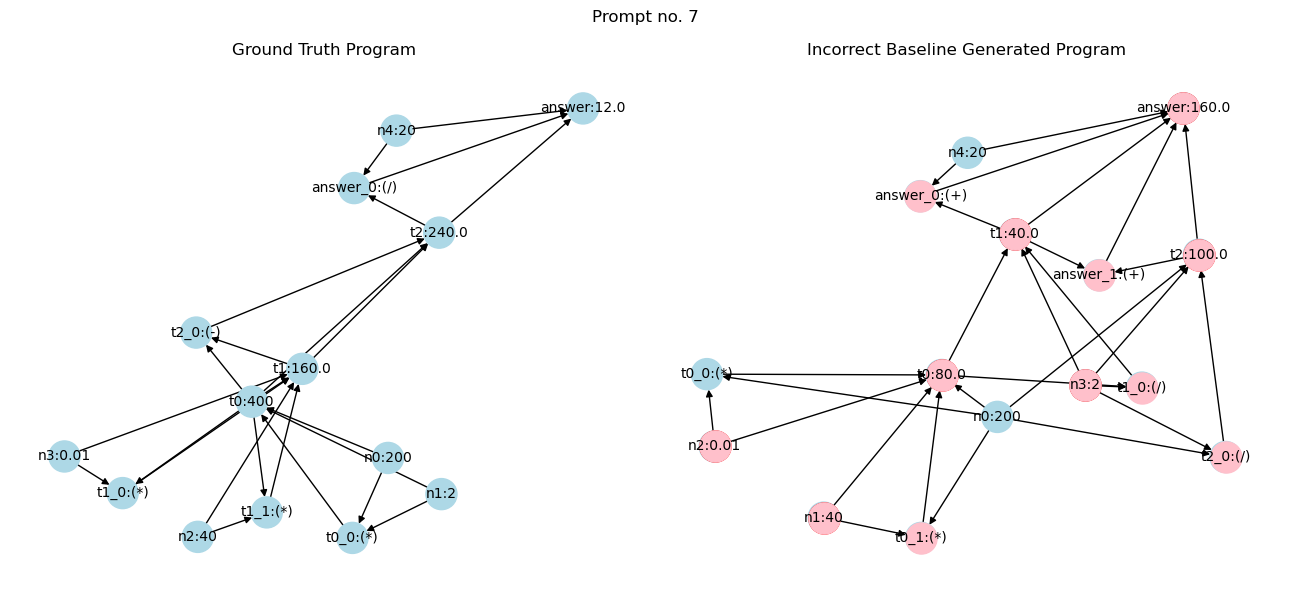

Unique nodes in GT Graph: {'n3', 't1_0:(*)', 'answer', 'answer_0:(/)', 't2_0:(-)', 't0', 't1', 't1_1:(*)', 't2', 'n1', 'n2'}
Unique nodes in Basline Graph: {'n3', 't0_1:(*)', 'answer', 't1_0:(/)', 'answer_1:(+)', 't0', 't1', 't2_0:(/)', 'answer_0:(+)', 't2', 'n1', 'n2'}
Unique edges in GT Graph: {('n1', 't0_0:(*)'), ('t0', 't2'), ('answer_0:(/)', 'answer'), ('n4', 'answer_0:(/)'), ('t1_1:(*)', 't1'), ('t2_0:(-)', 't2'), ('t0', 't1_1:(*)'), ('t1', 't2'), ('t2', 'answer_0:(/)'), ('t1', 't2_0:(-)'), ('n2', 't1_1:(*)'), ('t1_0:(*)', 't1'), ('t0', 't2_0:(-)'), ('n3', 't1_0:(*)'), ('n2', 't1'), ('t0', 't1_0:(*)')}
Unique edges in GT Graph: {('n0', 't0_1:(*)'), ('t1_0:(/)', 't1'), ('n2', 't0_0:(*)'), ('t0', 't1_0:(/)'), ('n1', 't0_1:(*)'), ('t1', 'answer_1:(+)'), ('t1', 'answer'), ('n3', 't2_0:(/)'), ('n0', 't2_0:(/)'), ('answer_0:(+)', 'answer'), ('t0_1:(*)', 't0'), ('t2_0:(/)', 't2'), ('t1', 'answer_0:(+)'), ('n4', 'answer_0:(+)'), ('n0', 't2'), ('n2', 't0'), ('answer_1:(+)', 'answer'), ('n

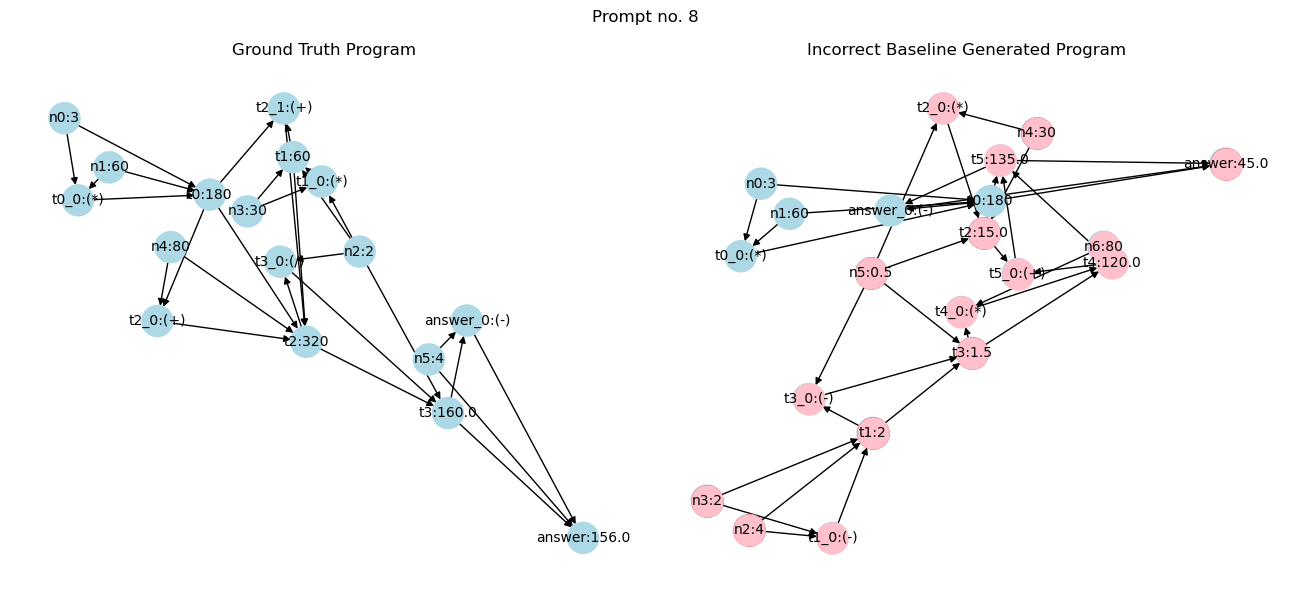

Unique nodes in GT Graph: {'n3', 't1_0:(*)', 't3', 't2_0:(+)', 'answer', 'n4', 't3_0:(/)', 't1', 'n5', 't2_1:(+)', 't2', 'n2'}
Unique nodes in Basline Graph: {'n3', 't2_0:(*)', 't3', 't3_0:(-)', 't4', 't4_0:(*)', 'n4', 'answer', 't5_0:(+)', 't5', 't1', 'n5', 't1_0:(-)', 'n6', 't2', 'n2'}
Unique edges in GT Graph: {('t1', 't2_1:(+)'), ('t2_1:(+)', 't2'), ('n5', 'answer'), ('t0', 't2_1:(+)'), ('t1', 't2'), ('t3', 'answer'), ('t0', 't2'), ('t2_0:(+)', 't2'), ('t2', 't3'), ('n2', 't3'), ('t0', 't2_0:(+)'), ('n4', 't2_0:(+)'), ('n5', 'answer_0:(-)'), ('t1_0:(*)', 't1'), ('t3', 'answer_0:(-)'), ('t2', 't3_0:(/)'), ('n3', 't1_0:(*)'), ('n2', 't1_0:(*)'), ('t3_0:(/)', 't3'), ('n2', 't3_0:(/)')}
Unique edges in GT Graph: {('n5', 't2'), ('t4', 't5'), ('n6', 't4_0:(*)'), ('n3', 't1_0:(-)'), ('n6', 't4'), ('t3', 't4_0:(*)'), ('n2', 't1_0:(-)'), ('t3', 't4'), ('t5', 'answer'), ('t5_0:(+)', 't5'), ('n5', 't3_0:(-)'), ('t0', 'answer'), ('t3_0:(-)', 't3'), ('n5', 't2_0:(*)'), ('t1', 't3_0:(-)'), ('t2_

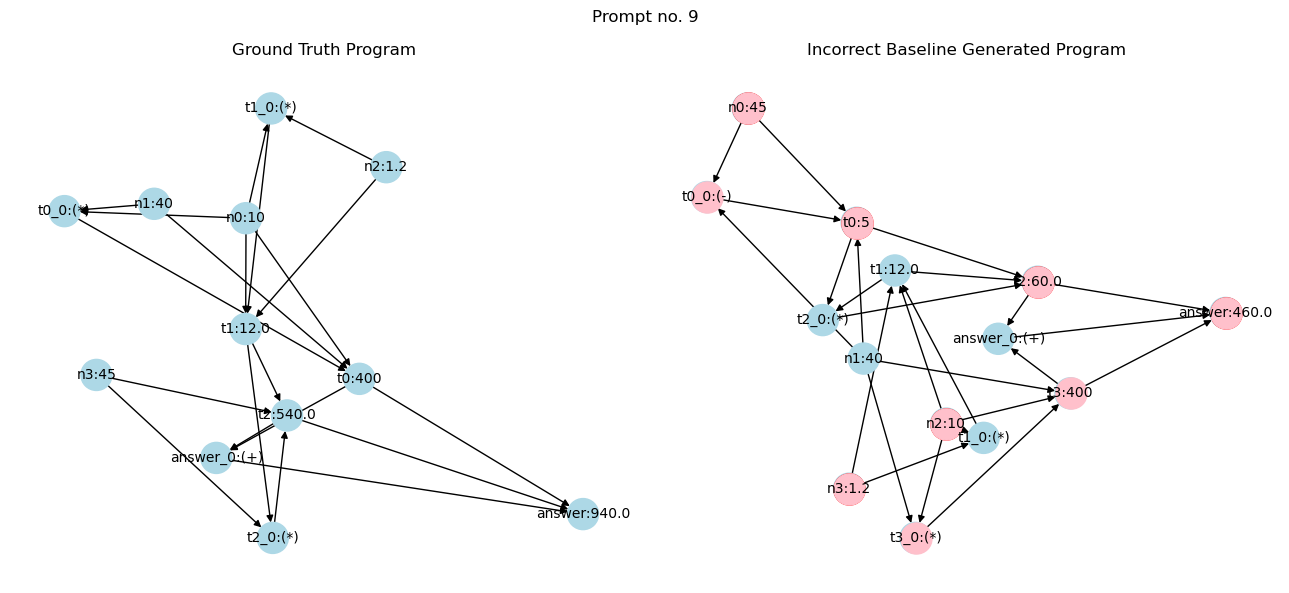

Unique nodes in GT Graph: {'n3', 'n0', 'answer', 't0_0:(*)', 't0', 't2', 'n2'}
Unique nodes in Basline Graph: {'n3', 'n0', 't3_0:(*)', 'answer', 't0_0:(-)', 't0', 't3', 't2', 'n2'}
Unique edges in GT Graph: {('n1', 't0_0:(*)'), ('t0_0:(*)', 't0'), ('n3', 't2_0:(*)'), ('t0', 'answer'), ('n0', 't0_0:(*)'), ('t0', 'answer_0:(+)'), ('n0', 't1'), ('n3', 't2'), ('n0', 't1_0:(*)')}
Unique edges in GT Graph: {('t3_0:(*)', 't3'), ('n2', 't3'), ('t0', 't2'), ('n2', 't3_0:(*)'), ('t0_0:(-)', 't0'), ('t0', 't2_0:(*)'), ('t3', 'answer_0:(+)'), ('n1', 't3'), ('n1', 't3_0:(*)'), ('n1', 't0_0:(-)'), ('n3', 't1'), ('n3', 't1_0:(*)'), ('t3', 'answer'), ('n0', 't0_0:(-)')}


In [ ]:
for gen, gt in zip(graph_lists[0], graph_lists[1]):
    display_graphs_nc(gen, gt)
    